In [ ]:
# Import necessary libraries
import cv2
import torch
from ultralytics import YOLO
import matplotlib.pyplot as plt
from collections import defaultdict

In [ ]:
# Load the model
model = YOLO("D:\Projects_Repo\Stealth_mode\model\\best.pt") 

<>:2: SyntaxWarning: invalid escape sequence '\P'
<>:2: SyntaxWarning: invalid escape sequence '\P'
C:\Users\hp\AppData\Local\Temp\ipykernel_9500\3357232907.py:2: SyntaxWarning: invalid escape sequence '\P'
  model = YOLO("D:\Projects_Repo\Stealth_mode\model\\best.pt")


In [ ]:
# Load the video
video_path = "D:\Projects_Repo\Stealth_mode\\video\\15sec_input_720p.mp4"
cap = cv2.VideoCapture(video_path)

<>:2: SyntaxWarning: invalid escape sequence '\P'
<>:2: SyntaxWarning: invalid escape sequence '\P'
C:\Users\hp\AppData\Local\Temp\ipykernel_9500\1191019509.py:2: SyntaxWarning: invalid escape sequence '\P'
  video_path = "D:\Projects_Repo\Stealth_mode\\video\\15sec_input_720p.mp4"


In [ ]:
# Initialize variables
player_id_counter = 0
player_id_map = {}
frame_index = 0
tracker_data = defaultdict(list)

In [ ]:
# Define a simple feature extractor (centroid-based)
def get_centroid(box):
    x1, y1, x2, y2 = box
    return ((x1 + x2) / 2, (y1 + y2) / 2)

def euclidean_distance(p1, p2):
    return ((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2) ** 0.5

In [ ]:
# Re-identification threshold (pixels)
distance_threshold = 50

In [ ]:
# Tracking loop
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    results = model.track(frame, persist=True, verbose=False)
    detections = results[0].boxes

    current_centroids = []
    current_ids = []

    for det in detections:
        cls = int(det.cls)
        if cls != 0:  # Class 0 = player
            continue
        box = det.xyxy[0].cpu().numpy()
        centroid = get_centroid(box)
        current_centroids.append(centroid)

    # Match current centroids with existing players
    for centroid in current_centroids:
        matched = False
        for pid, past_centroids in player_id_map.items():
            if euclidean_distance(past_centroids[-1], centroid) < distance_threshold:
                player_id_map[pid].append(centroid)
                tracker_data[pid].append((frame_index, centroid))
                matched = True
                break
        if not matched:
            player_id_counter += 1
            player_id_map[player_id_counter] = [centroid]
            tracker_data[player_id_counter].append((frame_index, centroid))

    frame_index += 1

cap.release()

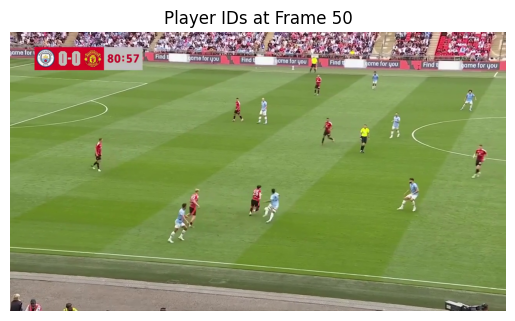

In [ ]:
# Show a single frame with player IDs
cap = cv2.VideoCapture(video_path)
cap.set(cv2.CAP_PROP_POS_FRAMES, 50)  # Jump to frame 50
ret, frame = cap.read()

for pid, points in tracker_data.items():
    for f_idx, (x, y) in points:
        if f_idx == 50:
            cv2.circle(frame, (int(x), int(y)), 10, (0, 255, 0), -1)
            cv2.putText(frame, f'ID:{pid}', (int(x), int(y)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Player IDs at Frame 50')
plt.show()


In [ ]:
# Save tracker data or print summary
for pid, locations in tracker_data.items():
    print(f"Player {pid}: {len(locations)} frames")

Player 1: 1 frames
Player 2: 10 frames
Player 3: 1 frames
Player 4: 1 frames
Player 5: 1 frames
Player 6: 3 frames
Player 7: 1 frames
Player 8: 1 frames
Player 9: 3 frames
